# Dog breed classification using Pytorch Estimators on Azure Machine Learning service

Have you ever seen a dog and not been able to tell the breed? Some dogs look so similar, that it can be nearly impossible to tell. For instance these are a few breeds that are difficult to tell apart:

#### Alaskan Malamutes vs Siberian Huskies
![Image of Alaskan Malamute vs Siberian Husky](http://cdn.akc.org/content/article-body-image/malamutehusky.jpg)

#### Whippet vs Italian Greyhound 
![Image of Whippet vs Italian Greyhound](http://cdn.akc.org/content/article-body-image/whippetitalian.jpg)

There are sites like http://what-dog.net, which use Microsoft Cognitive Services to be able to make this easier. 

In this tutorial, you will learn how to train your own image classification model using transfer learning. The Azure Machine Learning python SDK's [PyTorch estimator](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-train-pytorch) enables you to easily submit PyTorch training jobs for both single-node and distributed runs on Azure compute. The model is trained to classify dog breeds using a pretrained ResNet18 model that has been trained on the [Stanford Dog dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/). This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. For time, we will use a subset of this dataset which includes 10 dog breeds.

## What is Azure Machine Learning service?
Azure Machine Learning service (Preview) is a cloud service that you can use to develop and deploy machine learning models. Using Azure Machine Learning service, you can track your models as you build, train, deploy, and manage them, all at the broad scale that the cloud provides.
![](https://docs.microsoft.com/en-us/azure/machine-learning/service/media/overview-what-is-azure-ml/aml.png)


## How can we use it for training image classification models?
Training machine learning models, particularly deep neural networks, is often a time- and compute-intensive task. Once you've finished writing your training script and running on a small subset of data on your local machine, you will likely want to scale up your workload.

To facilitate training, the Azure Machine Learning Python SDK provides a high-level abstraction, the estimator class, which allows users to easily train their models in the Azure ecosystem. You can create and use an Estimator object to submit any training code you want to run on remote compute, whether it's a single-node run or distributed training across a GPU cluster. For PyTorch and TensorFlow jobs, Azure Machine Learning also provides respective custom PyTorch and TensorFlow estimators to simplify using these frameworks.

### Steps to train with a Pytorch Estimator:
In this tutorial, we will:
- Connect to an Azure Machine Learning service Workspace 
- Create a remote compute target
- Upload your training data (Optional)
- Create your training script
- Create an Estimator object
- Submit your training job

## Prerequisites
* Understand the [architecture and terms](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture) introduced by Azure Machine Learning
![](https://docs.microsoft.com/en-us/azure/machine-learning/service/media/concept-azure-machine-learning-architecture/workflow.png)

In [ ]:
##make sure the latest version is installed. 0.1.74
!pip install --upgrade azureml-sdk

In [1]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

SDK version: 0.1.65


## Initialize workspace
We will provide a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object to use in this tutorial. If you want to use a different subscription, you can enter the information below and create a Workspace. This step checks to see if the workspace is created and writes a `config.json` that can be used to reference the workspace in other notebooks. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`.

**You will be asked to login during this step. Please use the AAD credentials provided to you.**

In [20]:
from azureml.core.workspace import Workspace

subscription_id = "f4a274f8-242a-48cc-b543-3b6a61f32a5f"
resource_group = "pycon-canada"
workspace_name = "pycon-canada"
workspace_region = "westeurope"

ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region,
                      create_resource_group = True,
                      exist_ok = True)
ws.write_config()

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Wrote the config file config.json to: /home/nbuser/library/aml_config/config.json
Found the config file in: /home/nbuser/library/aml_config/config.json
Workspace name: pycon
Azure region: westeurope
Subscription id: 4feb84f6-2c10-4536-9c8a-0a2360eabfc5
Resource group: testPyCon


## Create a remote compute target
For this tutorial, we already have a  [Azure Batch AI](https://docs.microsoft.com/azure/batch-ai/overview) cluster with a NC6s_v2, P100 GPU machine, created to use as the [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) to execute your training script on. 

This code creates a cluster for you if it does not already exist in your workspace.

**Creation of the cluster takes approximately 5 minutes.** If the cluster is already in your workspace this code will skip the cluster creation process.

In [22]:
from azureml.core.compute import ComputeTarget, BatchAiCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "pycon"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = BatchAiCompute.provisioning_configuration(vm_size='Standard_NC6s_v2', 
                                                                autoscale_enabled=True,
                                                                cluster_min_nodes=1, 
                                                                cluster_max_nodes=1)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    compute_target.wait_for_completion(show_output=True)

    # Use the 'status' property to get a detailed status for the current cluster. 
    print(compute_target.status.serialize())

Found existing compute target.


## Upload training data
The dataset we will use consists of ~150 images per class. Some breeds have more, while others have less. Each class has about 100 training images each for dog breeds, with ~50 validation images for each class. We will look at 10 classes in this tutorial.

To make the data accessible for remote training, you will need to upload the data from your local machine to the cloud. AML provides a convenient way to do so via a [Datastore](https://docs.microsoft.com/azure/machine-learning/service/how-to-access-data). The datastore provides a mechanism for you to upload/download data, and interact with it from your remote compute targets. 

We have already done this step for you, so you will just need to register the Azure Blob Storage with your datastore.

You can view the subset of the data used [here](https://github.com/heatherbshapiro/pycon-canada/tree/master/breeds-10). 

In [23]:
from azureml.core.datastore import Datastore
ds= Datastore.get(ws,"breeds")

Now let's get a reference to the path on the datastore with the training data. We can do so using the `path` method. In the next section, we can then pass this reference to our training script's `--data_dir` argument. 

In [10]:
path_on_datastore = 'breeds-10'
ds_data = ds.path(path_on_datastore)
print(ds_data)

$AZUREML_DATAREFERENCE_c0c46b2eb7d84f319b78fc51b27a5af3


## Download the Data

If you are interested in downloading the data locally, you can run `ds.download("./", 'breeds-10')`. This might take several minutes.

## Train model on the remote compute
Now that you have your data and training script prepared, you are ready to train on your remote compute cluster. You can take advantage of Azure compute to leverage GPUs to cut down your training time.     

### Create a project directory
Create a directory that will contain all the necessary code from your local machine, in this case, Azure Notebooks, that you will need access to on the remote resource. This includes the training script and any additional files your training script depends on.

In [ ]:
import os

project_folder = './pytorch-dog-breeds-10'
os.makedirs(project_folder, exist_ok=True)

### Prepare training script
Now you will need to create your training script. In this tutorial, the training script is already provided for you at `pytorch_train.py`. In practice, you should be able to take any custom training script as is and run it with AML without having to modify your code.

However, if you would like to use AML's [tracking and metrics](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#metrics) capabilities, you will have to add a small amount of AML code inside your training script. 

In `pytorch_train_10.py`, we will log some metrics to our AML run. To do so, we will access the AML run object within the script:
```Python
from azureml.core.run import Run
run = Run.get_context()
```
Further within `pytorch_train_10.py`, we log the learning rate and momentum parameters, and the best validation accuracy the model achieves:
```Python
run.log('lr', np.float(learning_rate))
run.log('momentum', np.float(momentum))

run.log('best_val_acc', np.float(best_acc))
```

Once your script is ready, copy the training script `pytorch_train_10.py` into your project directory.

In [ ]:
import shutil
shutil.copy('pytorch_train_10.py', project_folder)

### Create an experiment
Create an [Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) to track all the runs in your workspace for this transfer learning PyTorch tutorial. 

**Please enter your own unique name so that you can track your specific runs.**

In [ ]:
from azureml.core import Experiment

experiment_name = <<ENTER UNIQUE NAME HERE>> ## An example would be "pytorch-dogs-hs"
experiment = Experiment(ws, name=experiment_name)

### Create a PyTorch estimator
The AML SDK's PyTorch estimator enables you to easily submit PyTorch training jobs for both single-node and distributed runs. For more information on the PyTorch estimator, refer [here](https://docs.microsoft.com/azure/machine-learning/service/how-to-train-pytorch). The following code will define a single-node PyTorch job.

In [ ]:
##BATCH AI
from azureml.train.dnn import PyTorch

script_params = {
    '--data_dir': ds_data.as_mount(),
    '--num_epochs': 10,
    '--output_dir': './outputs'
}

estimator = PyTorch(source_directory=project_folder, 
                    script_params=script_params,
                    compute_target=compute_target, 
                    entry_script='pytorch_train_10.py',
                    use_gpu=True)


The `script_params` parameter is a dictionary containing the command-line arguments to your training script `entry_script`. Please note the following:
- We passed our training data reference `ds_data` to our script's `--data_dir` argument. This will 1) mount our datastore on the remote compute and 2) provide the path to the training data `breeds` on our datastore.
- We specified the output directory as `./outputs`. The `outputs` directory is specially treated by AML in that all the content in this directory gets uploaded to your workspace as part of your run history. The files written to this directory are therefore accessible even once your remote run is over. In this tutorial, we will save our trained model to this output directory.

To leverage the Azure VM's GPU for training, we set `use_gpu=True`.

### Submit job
Run your experiment by submitting your estimator object. Note that this call is asynchronous.

In [ ]:
run = experiment.submit(estimator)
print(run.get_details())

### Monitor your run
You can monitor the progress of the run with a Jupyter widget. Like the run submission, the widget is asynchronous and provides live updates every 10-15 seconds until the job completes.

In [ ]:
from azureml.train.widgets import RunDetails
RunDetails(run).show()

### Test the web service on model with 120 classes
The run will take a few minutes to run on a Standard_NC6s_v2 VM with one node per job. You can also test images against a model that was trained the same way with 120 classes instead of 10. We will send the data as a JSON string to the web service hosted in ACI and use the SDK's `run` API to invoke the service. Here we will take an arbitrary image from our validation data to predict on.

**If at any point throughout the process you want to test an existing webservice while you wait, please try out the `webservice-test.ipynb`**

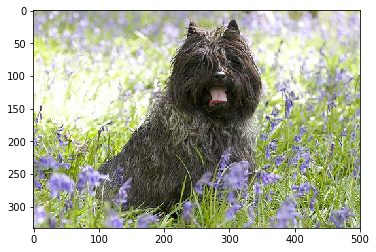

In [16]:
# importing the requests library 
import requests 
import os, json, base64
from io import BytesIO
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
import urllib.request
import io

##Get random dog
def get_random_dog():
    r = requests.get(url ="https://dog.ceo/api/breeds/image/random")
    URL= r.json()['message']
    return URL

##Get Random Dog Image
URL = get_random_dog()

##whippet Example 
# URL="https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12223018/Whippet-On-White-03.jpg"

##italian greyhound Example
# URL="https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12231757/Italian-Greyhound-On-White-03.jpg"

##chihuahua Example
# URL ="https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12213613/Chihuahua-onWhite-13.jpg"

with urllib.request.urlopen(URL) as url:
    test_img = io.BytesIO(url.read())

# ## If you downloaded the dataset, you can try this arbitrary image from the test dataset
# # test_img = os.path.join('breeds-10', 'val', 'n02085620-Chihuahua', 'n02085620_1271.jpg') 

plt.imshow(Image.open(test_img))


In [17]:

def imgToBase64(img):
    """Convert pillow image to base64-encoded image"""
    imgio = BytesIO()
    img.save(imgio, 'JPEG')
    img_str = base64.b64encode(imgio.getvalue())
    return img_str.decode('utf-8')

base64Img = imgToBase64(Image.open(test_img))
# api-endpoint 
scoringURI = "http://137.117.58.22:80/score"

data = {'data':base64Img} 
headers = {'content-type': 'application/json'}
    
# sending post request and saving response as response object 
r = requests.post(url = scoringURI, data=json.dumps(data), headers=headers)
r.json()

'{"label": "briard", "probability": "0.3480497"}'

### Register the model
Once the run completes, we can register the model that was created.

**Please use a unique name for the model**

In [ ]:
## if you need to reference the run object specifically uncomment this section

# from azureml.core import Run
# run = Run(experiment, run_id="") 

In [ ]:
model = run.register_model(model_name= <<INSERT UNIQUE MODEL NAME>>, model_path = 'outputs/model.pt')
print(model.name, model.id, model.version, sep = '\t')

## Deploy model as web service
Once you have your trained model, you can deploy the model on Azure. In this tutorial, we will deploy the model as a web service in [Azure Container Instances](https://docs.microsoft.com/en-us/azure/container-instances/) (ACI). For more information on deploying models using Azure ML, refer [here](https://docs.microsoft.com/azure/machine-learning/service/how-to-deploy-and-where).

### Create scoring script

First, we will create a scoring script that will be invoked by the web service call. Note that the scoring script must have two required functions:
* `init()`: In this function, you typically load the model into a `global` object. This function is executed only once when the Docker container is started. 
* `run(input_data)`: In this function, the model is used to predict a value based on the input data. The input and output typically use JSON as serialization and deserialization format, but you are not limited to that.

Refer to the scoring script `pytorch_score.py` for this tutorial. Our web service will use this file to predict whether an image is an ant or a bee. When writing your own scoring script, don't forget to test it locally first before you go and deploy the web service.

### Create environment file
Then, we will need to create an environment file (`myenv.yml`) that specifies all of the scoring script's package dependencies. This file is used to ensure that all of those dependencies are installed in the Docker image by AML. In this case, we need to specify `torch`, `torchvision`, `pillow`, and `azureml-sdk`.

In [ ]:
%%writefile myenv.yml
name: myenv
channels:
  - defaults
dependencies:
  - pip:
    - torch
    - torchvision
    - pillow
    - azureml-core

### Configure the container image
Now configure the Docker image that you will use to build your ACI container.

In [ ]:
from azureml.core.image import ContainerImage

image_config = ContainerImage.image_configuration(execution_script='pytorch_score.py', 
                                                  runtime='python', 
                                                  conda_file='myenv.yml',
                                                  description='Image with dog breed model')

### Configure the ACI container
We are almost ready to deploy. Create a deployment configuration file to specify the number of CPUs and gigabytes of RAM needed for your ACI container. While it depends on your model, the default of `1` core and `1` gigabyte of RAM is usually sufficient for many models.

In [ ]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'data': 'dog_breeds',  'method':'transfer learning', 'framework':'pytorch'},
                                               description='Classify dog breeds using transfer learning with PyTorch')

### Deploy the registered model
Finally, let's deploy a web service from our registered model. First, retrieve the model from your workspace.

In [ ]:
from azureml.core.model import Model

model = Model(ws, name='dogs')

Then, deploy the web service using the ACI config and image config files created in the previous steps. We pass the `model` object in a list to the `models` parameter. If you would like to deploy more than one registered model, append the additional models to this list.

** Please use a unique service name**

In [ ]:
%%time
from azureml.core.webservice import Webservice

service_name = <<INSERT UNIQUE SERVICE NAME>>
service = Webservice.deploy_from_model(workspace=ws,
                                       name=service_name,
                                       models=[model],
                                       image_config=image_config,
                                       deployment_config=aciconfig,)

service.wait_for_deployment(show_output=True)
print(service.state)

If your deployment fails for any reason and you need to redeploy, make sure to delete the service before you do so: `service.delete()`

**Tip: If something goes wrong with the deployment, the first thing to look at is the logs from the service by running the following command:**

In [ ]:
service.get_logs()

Get the web service's HTTP endpoint, which accepts REST client calls. This endpoint can be shared with anyone who wants to test the web service or integrate it into an application.

In [ ]:
print(service.scoring_uri)

### Test the web service
Finally, let's test our deployed web service. We will send the data as a JSON string to the web service hosted in ACI and use the SDK's `run` API to invoke the service. Here we will take an arbitrary image from online to predict on. This is the same as above, but now we are testing on our own trained model. You can use any dog image, but please remember we only trained on 10 classes.

In [ ]:
from skimage import io
from PIL import Image
import urllib.request
import io

##Get random dog
def get_random_dog():
    r = requests.get(url ="https://dog.ceo/api/breeds/image/random")
    URL= r.json()['message']
    return URL

##Get Random Dog Image
URL = get_random_dog()

##whippet Example 
# URL="https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12223018/Whippet-On-White-03.jpg"

##italian greyhound Example
# URL="https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12231757/Italian-Greyhound-On-White-03.jpg"

##chihuahua Example
# URL ="https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12213613/Chihuahua-onWhite-13.jpg"

with urllib.request.urlopen(URL) as url:
    test_img = io.BytesIO(url.read())

# ## If you downloaded the dataset, you can try this arbitrary image from the test dataset
# # test_img = os.path.join('breeds-10', 'val', 'n02085620-Chihuahua', 'n02085620_1271.jpg') 

plt.imshow(Image.open(test_img))

##whippet
# URL="https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12223018/Whippet-On-White-03.jpg"

##italian greyhound
# URL="https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12231757/Italian-Greyhound-On-White-03.jpg"


with urllib.request.urlopen(URL) as url:
    test_img = io.BytesIO(url.read())

plt.imshow(Image.open(test_img))

In [ ]:
def imgToBase64(img):
    """Convert pillow image to base64-encoded image"""
    imgio = BytesIO()
    img.save(imgio, 'JPEG')
    img_str = base64.b64encode(imgio.getvalue())
    return img_str.decode('utf-8')

base64Img = imgToBase64(Image.open(test_img))

result = service.run(input_data=json.dumps({'data': base64Img}))
print(json.loads(result))

### Delete web service
Once you no longer need the web service, you should delete it.

In [ ]:
service.delete()